In [58]:
import numpy as np
import pandas as pd


from typing import Any , Literal

from src.data import DATAVENDOR

def eval_drawdown(v : pd.Series | np.ndarray | Any , how : Literal['exp' , 'lin'] = 'lin'):
    if isinstance(v , np.ndarray): v = pd.Series(v)
    if how == 'lin':
        cum = v.cumsum() + 1.
        cummax = cum.cummax()
        cummdd = cummax - cum
    else:
        cum = (v + 1.).cumprod()
        cummax = cum.cummax()
        cummdd = 1 - cum / cummax
    return cummdd

def eval_drawdown_st(v : pd.Series | np.ndarray | Any , how : Literal['exp' , 'lin'] = 'lin'):
    if isinstance(v , np.ndarray): v = pd.Series(v)
    if how == 'lin':
        cum = v.cumsum() + 1.
    else:
        cum = (v + 1.).cumprod()
    return cum.expanding().apply(lambda x: x.argmax(), raw=True).astype(int)

def eval_max_drawdown(v : pd.Series | np.ndarray | Any , how : Literal['exp' , 'lin'] = 'lin'):
    dd , st = eval_drawdown(v , how) , eval_drawdown_st(v , how)
    mdd = dd.max()
    idx_ed = int(dd.argmax())
    idx_st = int(st.iloc[idx_ed])

    return mdd , idx_st , idx_ed

def eval_pf_stats(grp : pd.DataFrame , mdd_period = True , **kwargs):
    period_len = abs(DATAVENDOR.CALENDAR.cd_diff(grp['start'].min() , grp['end'].max())) + 1
    period_n   = len(grp)

    with np.errstate(divide = 'ignore' , invalid = 'ignore'):
        pf_ret = np.prod(grp['pf'] + 1) - 1.
        bm_ret = np.prod(grp['bm'] + 1) - 1.
        excess = (pf_ret - bm_ret)
        ex_ann = np.power(np.prod(1 + grp['excess']) , 365 / period_len) - 1
        # pf_mdd = eval_max_drawdown(grp['pf'] , 'exp')
        ex_mdd , ex_mdd_st , ex_mdd_ed = eval_max_drawdown(grp['excess'] , 'lin')
        te     = np.std(grp['excess']) * np.sqrt(365 * period_n / period_len)
        ex_ir  = ex_ann / te
        ex_calmar = ex_ann / ex_mdd
        turn   = np.sum(grp['turn'])
        rslt = pd.DataFrame({'pf':pf_ret , 'bm':bm_ret , 'excess' : excess , 'annualized' : ex_ann , 'mdd' : ex_mdd , 
                             'te' : te , 'ir' : ex_ir , 'calmar' : ex_calmar , 'turnover' : turn} , index = [0])
    if mdd_period:
        rslt['mdd_period'] = ['{}-{}'.format(grp['end'].iloc[ex_mdd_st] , grp['end'].iloc[ex_mdd_ed])]
    return rslt.assign(**kwargs)

def cum_ret(x : pd.Series | pd.DataFrame , how : Literal['exp' , 'lin'] = 'lin' , 
            groupby : str | list[str] | None = None):
    x = x.fillna(0)
    if how == 'lin':
        return x.cumsum() if groupby is None else x.groupby(groupby , observed=True).cumsum()
    else:
        return (x + 1).cumprod() - 1 if groupby is None else (x + 1).groupby(groupby , observed=True).cumprod() - 1

def cum_peak(x : pd.Series | pd.DataFrame , groupby : str | list[str] | None = None):
    return x.cummax() if groupby is None else x.groupby(groupby , observed=True).cummax()

def eval_uncovered_max_drawdown(dd : pd.Series , groupby : str | list[str] | None = None):
    if groupby is None:
        umd = dd * 0.
        umd.iloc[0] = dd.iloc[0]
        for i , d in enumerate(dd[1:] , 1):
            if d < 0:
                umd.iloc[i] = min(umd.iloc[i - 1] , d)
    else:
        umd = dd.groupby(groupby , observed=True , group_keys = False).apply(eval_uncovered_max_drawdown)
    return umd

def eval_detailed_drawdown(pf : pd.Series , groupby : str | list[str] | None = None):
    '''
    based on the pf , calculate the detailed drawdown , including:
    cum_ret , peak , drawdown , uncovered_max_drawdown , recover_ratio
    '''
    df = pf.to_frame('pf')
    df['cum_ret'] = cum_ret(df['pf'] , how = 'exp' , groupby = groupby)
    df['peak'] = cum_peak(df['cum_ret'] , groupby = groupby)
    df['drawdown'] = (df['cum_ret'] + 1) / (df['peak'] + 1) - 1
    df['uncovered_max_drawdown'] = eval_uncovered_max_drawdown(df['drawdown'] , groupby = groupby)
    df['recover_ratio'] = (1 - df['drawdown'] / df['uncovered_max_drawdown']).fillna(1)

    df['warning'] = (df['recover_ratio'].fillna(0) < 0.25) * (df['uncovered_max_drawdown'] < -0.1) * 1.0

    df['stopped'] = df['pf'] * (1- df.groupby(groupby , observed=True , group_keys = False)['warning'].shift(1))
    df['stopped'] = np.exp(df['stopped'].cumsum()) - 1
    return df

s = pd.Series(['A'] * 5 + ['B'] * 5 , name = 'group')
dd = pd.Series(np.random.randn(10) / 10 , index = s)
eval_detailed_drawdown(dd , groupby = 'group')

,pf,cum_ret,peak,drawdown,uncovered_max_drawdown,recover_ratio,warning,stopped
group,,,,,,,,
A,-0.010077,-0.010077,-0.010077,0.000000,0.000000,1.000000,0.0,NaN
A,-0.124622,-0.133443,-0.010077,-0.124622,-0.124622,0.000000,1.0,-0.117170
A,-0.146795,-0.260649,-0.010077,-0.253123,-0.253123,0.000000,1.0,-0.117170
A,0.103728,-0.183958,-0.010077,-0.175651,-0.253123,0.306065,0.0,-0.117170
A,-0.320778,-0.445727,-0.010077,-0.440084,-0.440084,0.000000,1.0,-0.359432
B,-0.097180,-0.097180,-0.097180,0.000000,0.000000,1.000000,0.0,NaN
B,0.074849,-0.029604,-0.029604,0.000000,0.000000,1.000000,0.0,-0.309646
B,0.036213,0.005537,0.005537,0.000000,0.000000,1.000000,0.0,-0.284189
B,0.216407,0.223142,0.223142,0.000000,0.000000,1.000000,0.0,-0.111243


In [1]:
from src.factor.util.agency.portfolio_conditioner import BaseConditioner , AccountAccessor
from typing import Any

from src.factor.util.stat.port_stat import eval_drawdown , eval_uncovered_max_drawdown

import pandas as pd
import numpy as np

a = np.random.randn(20) / 10


main path: /Users/mengkjin/workspace/learndl
src.INSTANCE_RECORD can be accessed to check ['trainer', 'account', 'factor']


In [2]:

class DrawdownConditioner(BaseConditioner):
    def conditions(self , accessor : AccountAccessor) -> pd.Series | Any:
        ret = accessor.pf
        drawdown = eval_drawdown(ret , how = 'exp')
        umd = eval_uncovered_max_drawdown(drawdown) # uncovered max drawdown
        recover_ratio = (1 - drawdown / umd.fillna(1))
        magnifier = ret * 0 + 1
        init_stop = 0.1
        add_stop = 0.05

        stop_threshold = init_stop

        for i , (dd , umd , rr) in enumerate(zip(drawdown.values , umd.values , recover_ratio.values)):
            if umd < -stop_threshold and rr < 0.25:
                if i >= 1 and magnifier.iloc[i-1] == 1:
                    stop_threshold = stop_threshold + add_stop
                magnifier.iloc[i] = 0
            if dd >= 0:
                stop_threshold = init_stop  
            # print(dd , stop_threshold)          
        return magnifier
    
DrawdownConditioner().conditioning(a)

(<src.factor.util.agency.portfolio_conditioner.AccountAccessor at 0x23d0016d0>,
 model_date
 0     1.0
 1     1.0
 2     1.0
 3     1.0
 4     1.0
 5     1.0
 6     1.0
 7     1.0
 8     1.0
 9     0.0
 10    1.0
 11    1.0
 12    1.0
 13    1.0
 14    1.0
 15    1.0
 16    1.0
 17    1.0
 18    1.0
 19    1.0
 Name: pf, dtype: float64)

,cum_ret,cum_ret_cond
0,-0.099790,-0.099790
1,0.064281,0.064281
2,0.123614,0.123614
3,0.251939,0.251939
4,0.287955,0.287955
5,0.197824,0.197824
6,0.199939,0.199939
7,0.295243,0.295243
8,0.175887,0.175887
9,0.242927,0.175887


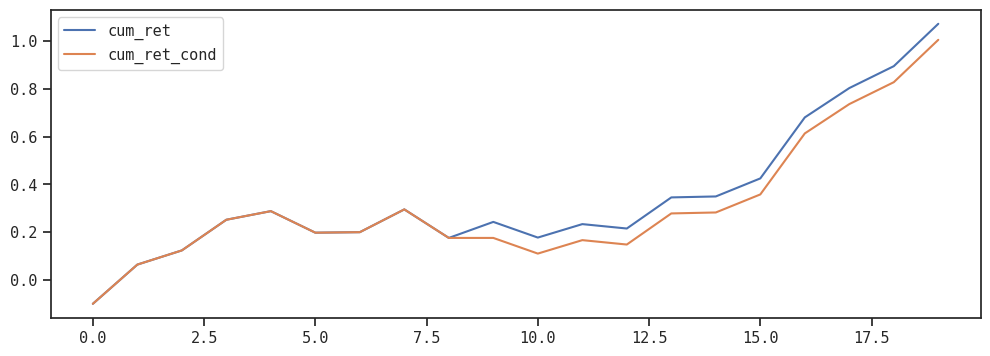

In [3]:
DrawdownConditioner().conditioned_pf_ret(a)

array([ 0.15280309,  0.15298108, -0.06987177, -0.00623742, -0.159291  ,
       -0.03969378,  0.16289479,  0.04594013, -0.02407699, -0.04274573])

In [2]:
a = {'a' : 1 , 
    'b' : 2 , 
    'c' : 3 , 
    'd' : 4 , 
    'e' : 5 , 
    'f' : 6 , 
    'g' : 7 , 
    'h' : 8}
b = {'a' : 2} 
c = a | b
a , b , c

({'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8},
 {'a': 2},
 {'a': 2, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8})

main path: /Users/mengkjin/workspace/learndl
src.INSTANCE_RECORD can be accessed to check ['trainer', 'account', 'factor']


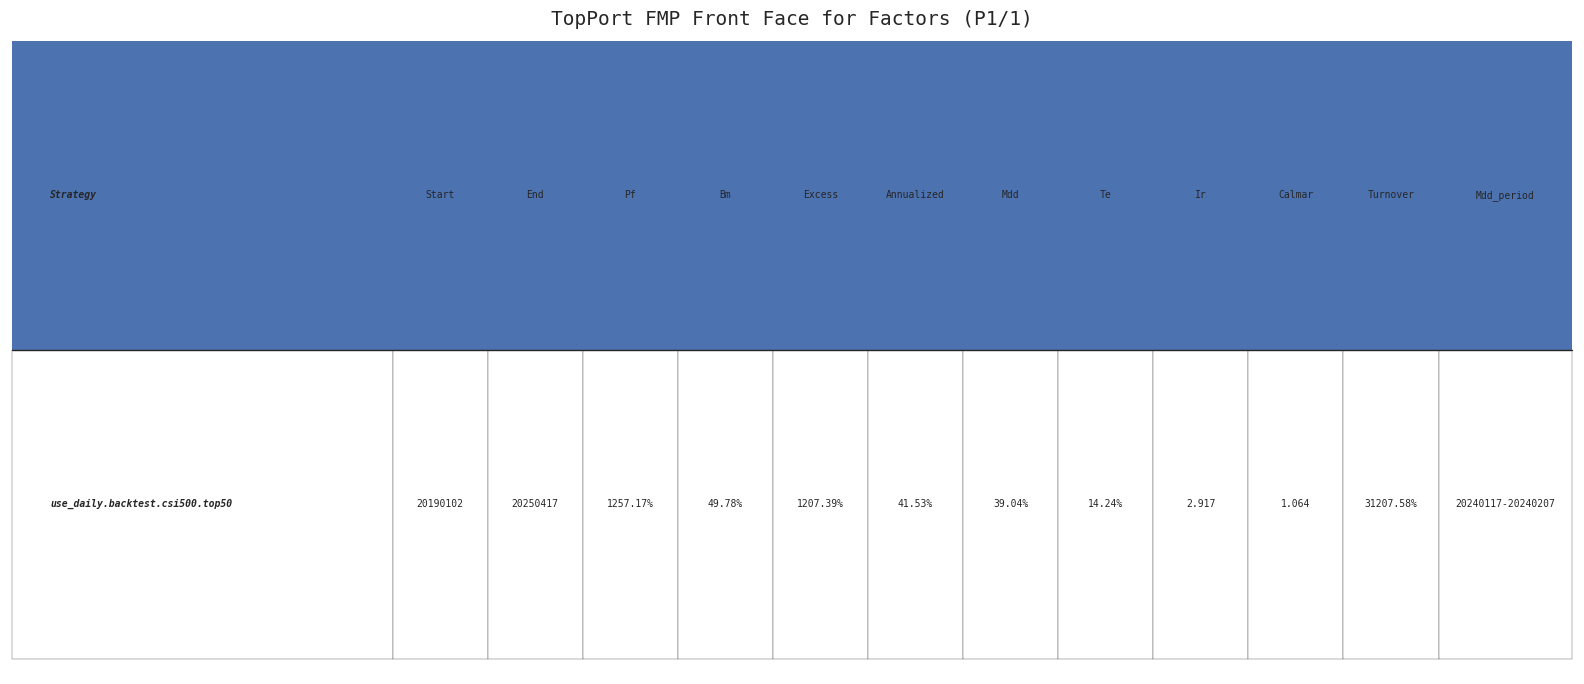

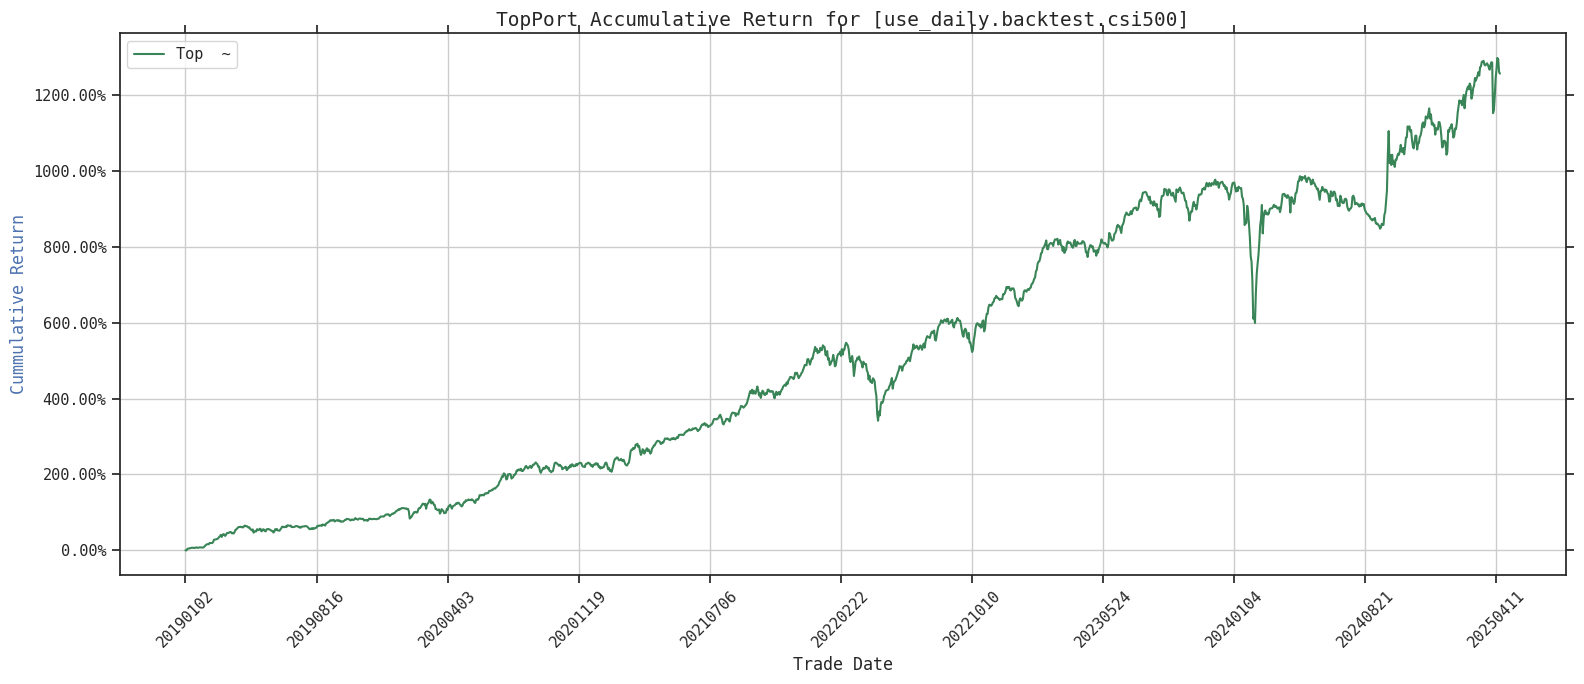

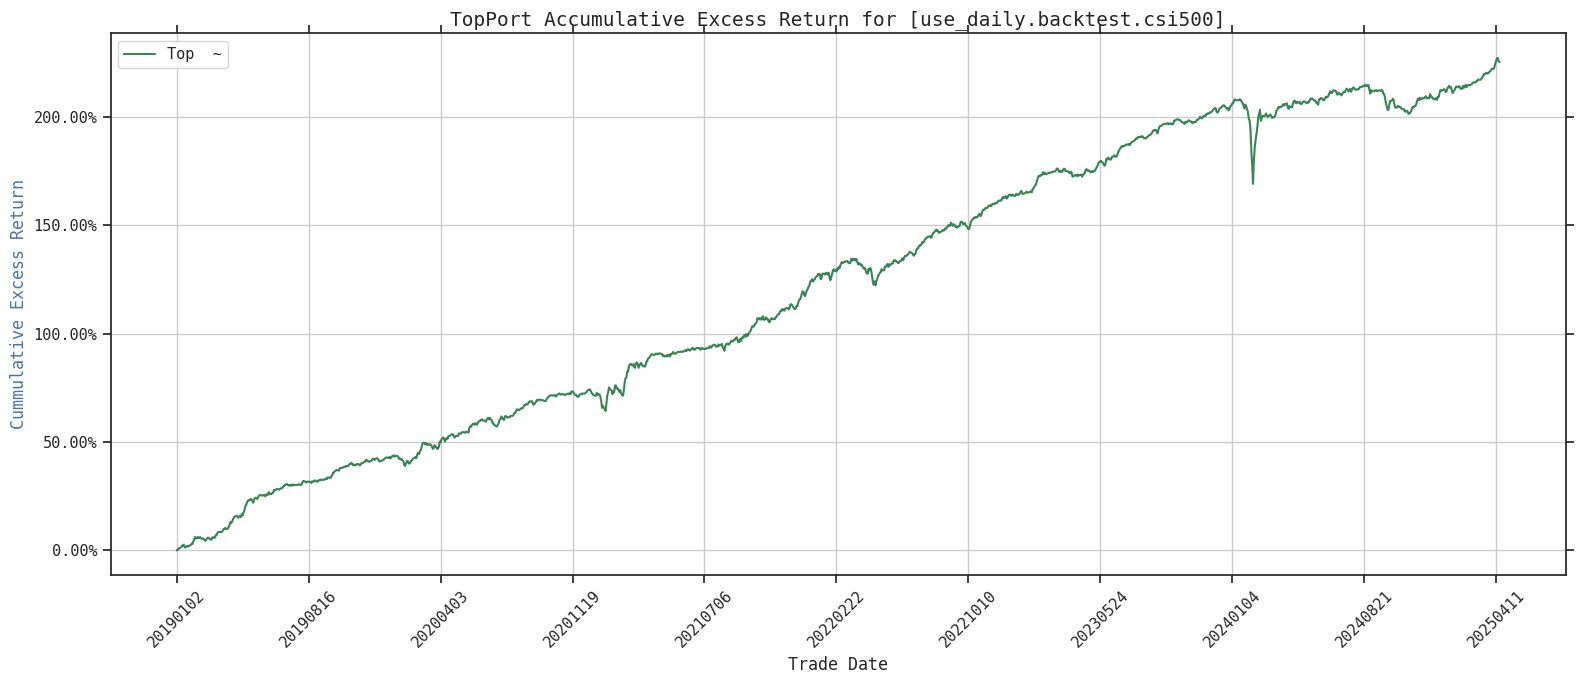

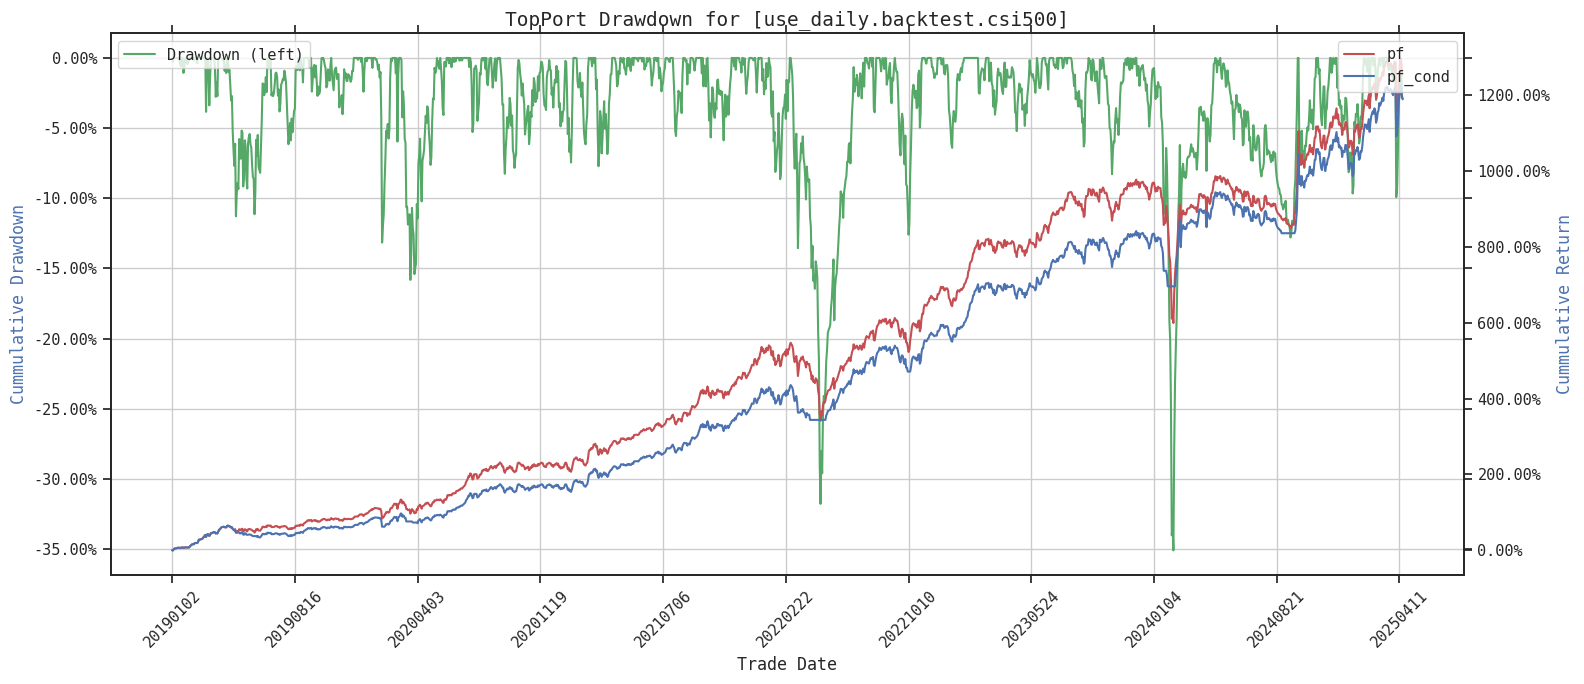

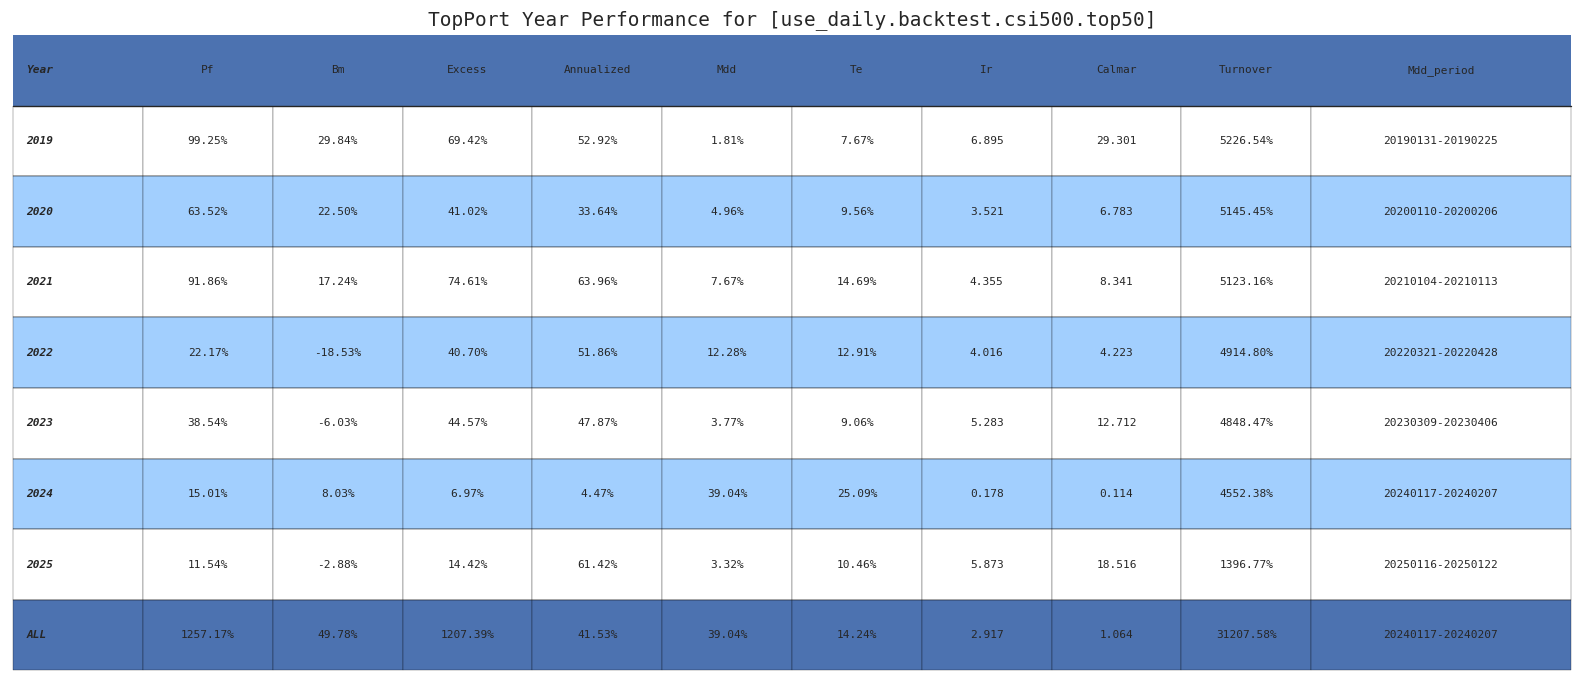

use_daily.backtest analyze Finished!


TradingPort(name='use_daily.backtest', alpha='big_combine', universe='top-1000', components=['sellside@huatai.master_combined@master_combined', 'sellside@dongfang.scores_v0@avg', 'gru_day_V1'], weights=[1.0, 1.0, 1.0], top_num=50, freq=1, init_value=1000000.0, backtest=True, test_start=20190101, test_end=20250430, benchmark='csi500')

In [1]:
from src.trading.util import TradingPort
tp = TradingPort.load('use_daily.backtest')
tp.analyze(trade_engine='yale')

In [1]:
%run src_runs/widget.py


Initiating project interface...
Project interface initiated successfully.


Script cmd : start cmd /k python e:\workspace\learndl\src_runs\0_git\1_pull_only.py --email 0
Script cmd : start cmd /k python e:\workspace\learndl\src_runs\1_autorun\0_daily_update.py --email 1
